In [ ]:
import numpy as np
import pandas as pd


import numpy as np
import pandas as pd
import sklearn as sk

import matplotlib.pyplot as plt
import seaborn as sns

import itertools

%matplotlib inline

SEED = 133742069
np.random.seed(SEED)

def generate_dataset(interval, sigma, N):
    a, b = interval
    xs = np.random.uniform(a, b, N)
    rs = np.random.normal(loc = 0, scale = sigma, size = N)
    ts = np.sin(2 * np.pi * xs) + rs
    return pd.DataFrame({ 'x': xs, 't': ts})

def generate_many_datasets(interval, sigma, points_per_dataset, number_of_datasets):
    return [generate_dataset(interval, sigma, points_per_dataset) for _ in range(number_of_datasets)]


def generate_powers(x, max_degree):
    return [x ** n for n in np.arange(max_degree)]



def generate_phi(xs, degree):
    phi = np.concatenate(generate_powers(xs, degree))
    return phi.reshape(degree, -1).T

def solve_weights(dataset, degree, lamb = 0):
    phi = generate_phi(dataset['x'], degree)
    b = phi.T @ dataset['t']
    A = phi.T @ phi
    lambda_I = np.eye(b.size) * lamb
    return np.linalg.solve(lambda_I + A,b)
    
def y(x, w):
    if np.isscalar(x):
        return generate_powers(x, w.size) @ w
    else:
        return np.vectorize(lambda x: y(x, w))(x)
    
def regu_term(lamb, w):
    return (lamb/2) * sum(w**2)

def square_error(w, dataset):
    return sum((y(dataset['x'], w) - dataset['t']) ** 2) / 2

def E(w, dataset, lamb = 0):
    return square_error(w, dataset) + regu_term(lamb, w)


def plot_one_dataset():
    intervalo = (0,2)
    ds = generate_dataset(intervalo, .5, 50)

    ws = solve_weights(ds, 10, 0.0005)
    rango = np.arange(intervalo[0], intervalo[1], 0.01)
    ys = y(rango, ws)
    sns.scatterplot(ds['x'], ds['t'])
    sns.lineplot(rango, np.sin(2 * np.pi * rango))
    sns.lineplot(rango, ys)
    

def get_training_group(data, group_size, i):
    index = np.arange(len(data.index))
    group_index = (index < group_size * i) | (index < group_size * (i + 1))
    return data.loc[group_index]
    

def get_group_index(group_size, i):
    index = np.arange(20)
    validation_index = (group_size * i , group_size * (i + 1))
    print(validation_index)
    return (index < validation_index[0]) | (index > validation_index[1])


class Model:
    def __init__(self, ws, degree, lbda, error):
        self.ws = ws
        self.degree = degree
        self.lbda = lbda
        self.error = error

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def plot_one_dataset(ds, intervalo, hiperparameters):
    m, l = hiperparameters
    ws = solve_weights(ds, m, l)
    rango = np.arange(intervalo[0], intervalo[1], 0.01)
    ys = y(rango, ws)
    sns.scatterplot(ds['x'], ds['t'])
    sns.lineplot(rango, np.sin(2 * np.pi * rango))
    sns.lineplot(rango, ys)


In [ ]:
## ACA EMPIEZA LA POSTA
intervalo = (0,1)
N = 25
sigma = 0.3

datasets = generate_many_datasets(intervalo, sigma, N, 200)

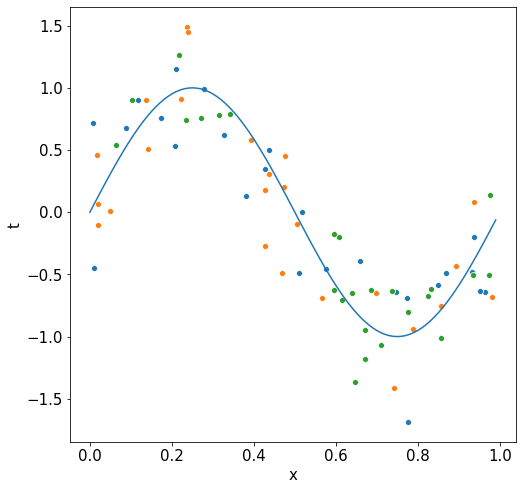

In [ ]:
# Ejercicio 1

plt.rc('font', size=15)

def plot_datasets(datasets):
  fig = plt.figure(figsize=(8,8))

  rango = np.arange(intervalo[0], intervalo[1], 0.01)
  for ds in datasets:
    sns.scatterplot(ds['x'], ds['t'])

  sns.lineplot(rango, np.sin(2 * np.pi * rango))
  fig.show()

plot_datasets(datasets[0:3])

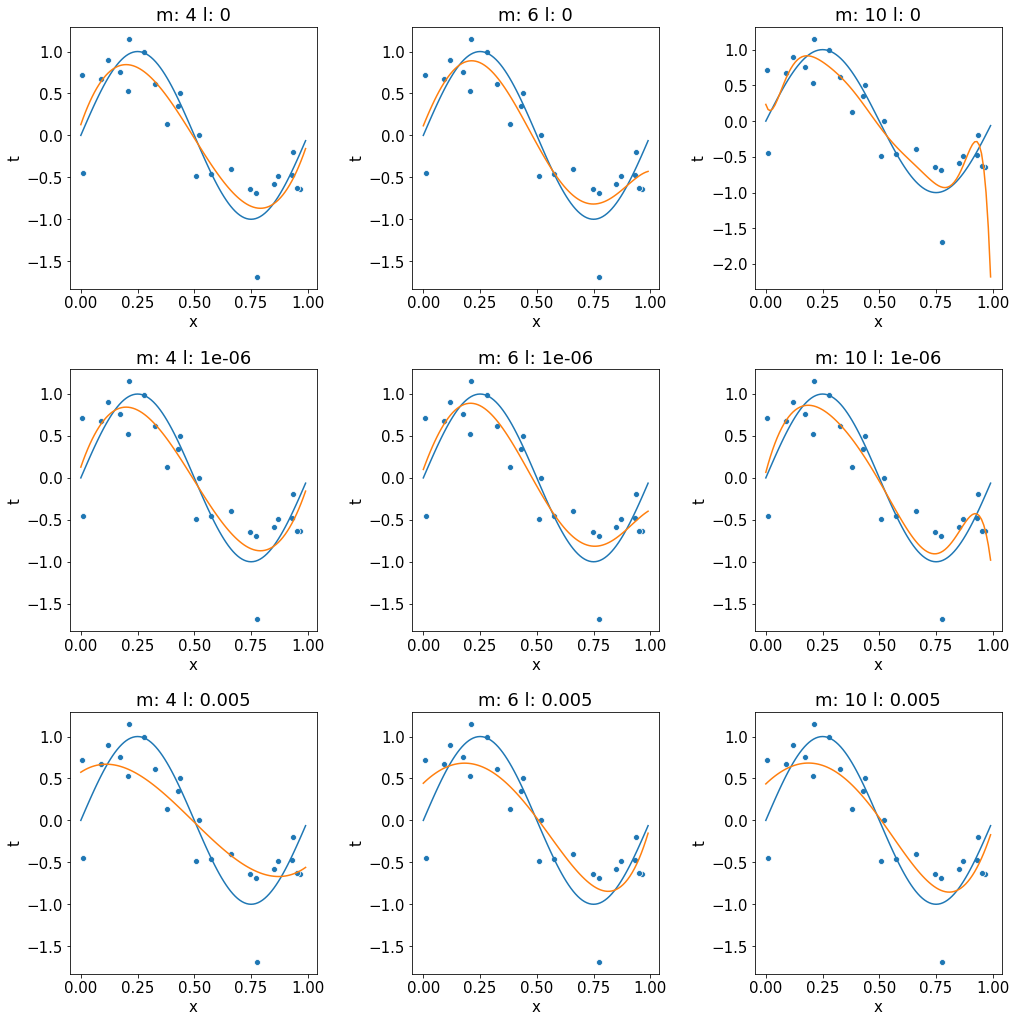

In [ ]:
# Ejercicio 2

def plot_solucion(ds, ws, hiperparameters, ax):
    m, l = hiperparameters
    ax.set_title("m: {} l: {}".format(m,l))

    rango = np.arange(intervalo[0], intervalo[1], 0.01)
    ys = y(rango, ws)
    sns.scatterplot(ds['x'], ds['t'], ax=ax)
    sns.lineplot(rango, np.sin(2 * np.pi * rango), ax=ax)
    sns.lineplot(rango, ys, ax=ax)


ms = [4, 6, 10]
lambdas = [0, 0.000001, 0.005]
soluciones = {}
mean_stds = {}

for m in ms:
  for l in lambdas:
    ws = solve_weights(datasets[0], m, l)
    soluciones[(m,l)] = ws
    
    errors_per_dataset = [E(ws, ds) for ds in datasets]
    mean_error = np.mean(errors_per_dataset)
    std_error = np.std(errors_per_dataset)

    mean_stds[(m,l)] = (mean_error, std_error)
    

fig, axes = plt.subplots(3, 3, figsize=(15,15))
fig.tight_layout(pad=3.5)

i = j = 0
for hiperparameters, ws in soluciones.items():
  plot_solucion(datasets[0], ws, hiperparameters, ax=axes[i][j])
  
  i += 1
  if i % 3 == 0:
    j += 1
    i = 0

fig.show()

In [ ]:
for (k1, k2),(m,s) in mean_stds.items():
  print("{} & {} & {:.2f} & {:.2f} \\\\".format(k1,k2,m,s))


4 & 0 & 1.39 & 0.38 \\
4 & 1e-06 & 1.39 & 0.38 \\
4 & 0.005 & 2.50 & 0.61 \\
6 & 0 & 1.38 & 0.38 \\
6 & 1e-06 & 1.39 & 0.38 \\
6 & 0.005 & 1.76 & 0.46 \\
10 & 0 & 2.75 & 1.96 \\
10 & 1e-06 & 1.62 & 0.55 \\
10 & 0.005 & 1.72 & 0.45 \\


In [ ]:
# Ejercicio 3

puntos_por_dataset = 10
datasets_de_training = 200
datasets_de_testing = 40
cantidad_de_datasets = datasets_de_training + datasets_de_testing
validation_group_size = 1

datasets_ej3 = generate_many_datasets(
    intervalo, sigma, puntos_por_dataset, cantidad_de_datasets)


In [ ]:
def split_ej3_datasets(datasets):
  last_dataset_index = len(datasets) - datasets_de_testing
  return (datasets[:last_dataset_index], datasets[last_dataset_index:])


class WsDeTraining:
    """
    Te devuelve los w para cada dataset de training dado un par (m, lambda).
    """
    def __init__(self, training_datasets, ms, lbdas):
        self.ws = {}
        for m in ms:
            for lbda in lbdas:
                self._llenar_para_hiperparametros(training_datasets, m, lbda)

    def _llenar_para_hiperparametros(self, training_datasets, m, lbda):
        ws = []
        for index, dataset in enumerate(training_datasets):
            try:
                w = solve_weights(dataset, m, lbda)
                ws.append(w)
            except Exception as e:
                print(dataset)
                print("===================")
                print("training dataset index: ", index)
                print("m: ", m)
                print("lambda: ", lbda)
                print("===================")
                raise e
        self.ws[m, lbda] = ws

    def para_hiperparametros(self, hiperparameters):
        return self.ws[hiperparameters]


def cartesian_product(ms, lambdas):
    return [(m, l) for m in ms for l in lambdas]


def errors_for_weights(ws, dataset):
    return [square_error(w, dataset) for w in ws]


def lista_sin(lista, indice_desde, indice_hasta):
    return lista[:indice_desde] + lista[indice_hasta + 1:]


def compute_mean_of_errors_for_weights(ws, dataset):
    return np.mean(errors_for_weights(ws, dataset))


def compute_mean_of_errors_for_weights_for_many_datasets(ws, datasets):
    return np.mean([
        compute_mean_of_errors_for_weights(ws, dataset)
        for dataset in datasets
    ])


def compute_error_with_mean_of_weights(ws, datasets):
    w = np.mean(ws, axis=0)
    return compute_mean_of_errors_for_weights_for_many_datasets([w], datasets) 


def compute_error_mean_for_weights_with_validation_group(
    datasets, ws, first_validation_element
):
    """
    Calcula el error promedio de las predicciones contra el dataset
    de índice validation_index, usando los ws calculados para 
    cada dataset de training.
    """
    validation_element_after_last = \
        first_validation_element + validation_group_size
    validation_datasets = datasets[
        first_validation_element:validation_element_after_last
    ]
    ws_sin_validation = lista_sin(
        ws, first_validation_element, validation_element_after_last)
    # return compute_mean_of_errors_for_weights_for_many_datasets(
    #     ws_sin_validation, validation_datasets)
    return compute_error_with_mean_of_weights(ws_sin_validation, validation_datasets)


def compute_error_mean_for_weights(datasets, ws_de_training):
    """
    Calcula el promedio de los errores calculados
    para estos ws contra cada uno de los datasets,
    tomando de a uno como validation.
    """
    errors = []
    for validation_element in range(0, len(datasets), validation_group_size):
        error = compute_error_mean_for_weights_with_validation_group(
            datasets, ws_de_training, validation_element
        )
        errors.append(error)
        group_index = validation_element // validation_group_size
        print(
            "Calculado error para grupo de validación {} de {}: {}" \
            .format(group_index + 1, len(datasets) // validation_group_size, error)
        )

    return np.mean(errors)
    

def cross_validate(datasets, ms, lambdas):
    """
    Calcula los errores de validación promedios
    para cada par de hiperparámetros m y lambda.
    """
    ws = WsDeTraining(datasets, ms, lambdas)
    hiperparameters_with_errors = []
    for hp in cartesian_product(ms, lambdas):
        print(
            "Haciendo cross-validation para hiperparámetros "
            "m = {} y lambda = {}." \
            .format(hp[0], hp[1])
        )
        error = compute_error_mean_for_weights(
            datasets, ws.para_hiperparametros(hp)
        )
        hiperparameters_with_errors.append((hp, error))
    return hiperparameters_with_errors



def train_and_calculate_mean_error(training_datasets, testing_datasets, m, lbda):
    errors = []
    weights = []
    for training_dataset in training_datasets:
        weights.append(solve_weights(training_dataset, m, lbda))
    weights_mean = np.mean(weights, axis=0)
    for testing_dataset in testing_datasets:
        errors.append(square_error(weights_mean, testing_dataset))
    return np.mean(errors)


def ej3():
    training, testing = split_ej3_datasets(datasets_ej3)
    hiperparameters_with_errors = cross_validate(training, ms, lambdas)
    (best_m, best_lambda), best_validation_error = \
        min(hiperparameters_with_errors, key=lambda x: x[1])

    print("m: {}, l: {}, err: {}".format(best_m, best_lambda, best_validation_error))

    testing_error = train_and_calculate_mean_error(
        training, testing, best_m, best_lambda)
    
    print("testing_error: ", testing_error)
    return best_m, best_lambda, training, testing, hiperparameters_with_errors
  

import time

start = time.time()
best_m, best_lambda, training, testing, hiperparameters_with_errors = ej3()
end = time.time()
print("Elapsed time: ", end - start)



Haciendo cross-validation para hiperparámetros m = 4 y lambda = 0.
Calculado error para grupo de validación 1 de 200: 0.5751986111497577
Calculado error para grupo de validación 2 de 200: 0.4619694530029914
Calculado error para grupo de validación 3 de 200: 0.27836242718012777
Calculado error para grupo de validación 4 de 200: 0.49271578470420424
Calculado error para grupo de validación 5 de 200: 0.48185432859447225
Calculado error para grupo de validación 6 de 200: 0.5889719483922271
Calculado error para grupo de validación 7 de 200: 0.767469230454955
Calculado error para grupo de validación 8 de 200: 0.6812990185057141
Calculado error para grupo de validación 9 de 200: 0.6229756045338947
Calculado error para grupo de validación 10 de 200: 0.5450691818817381
Calculado error para grupo de validación 11 de 200: 0.49351392183622383
Calculado error para grupo de validación 12 de 200: 0.4902002272682435
Calculado error para grupo de validación 13 de 200: 0.6437157046089732
Calculado error 

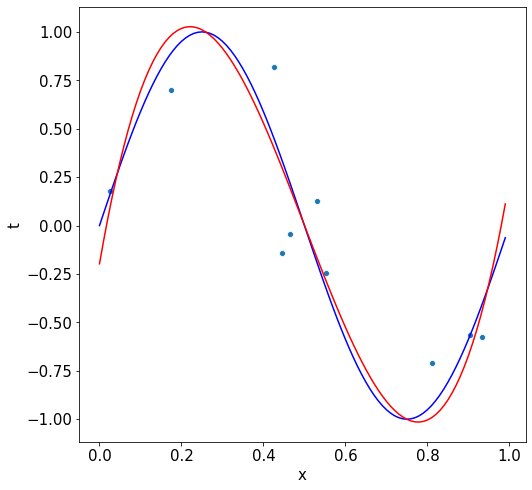

In [ ]:
# Ploteamos la curva generada por el w promedio

w_promedio = np.mean([
    solve_weights(dataset, best_m, best_lambda)
    for dataset in training
], axis=0)


fig, axes = plt.subplots(1, figsize=(8,8))
# plot_solucion(testing, w_promedio, (best_m, best_lambda), ax=axes)


rango = np.arange(0, 1, 0.01)
ys = y(rango, w_promedio)
sns.scatterplot(testing[0]['x'], testing[0]['t'])
sns.lineplot(rango, np.sin(2 * np.pi * rango), color='blue')
sns.lineplot(rango, ys, color='red')

In [ ]:
print("cross validation errors")

for (m,l), e in hiperparameters_with_errors:
  print("{} & {} & {:.3f} \\\\".format(m,l,e))

print()
testing_error = square_error(w_promedio, testing)
print("testing error:", testing_error)
print("testing mean error:", testing_error/len(testing))

cross validation errors
4 & 0 & 0.458 \\
4 & 1e-06 & 0.458 \\
4 & 0.005 & 1.320 \\
6 & 0 & 2.119 \\
6 & 1e-06 & 0.511 \\
6 & 0.005 & 0.853 \\
10 & 0 & 655367.209 \\
10 & 1e-06 & 0.539 \\
10 & 0.005 & 0.725 \\



TypeError: ignored

In [ ]:
def sin_square_error(testing_ds):
    sin_ds = pd.DataFrame({ 'x': testing_ds['x'], 't': np.sin(2 * np.pi * testing_ds['x']) })

    return sum((sin_ds['t'] - testing_ds['t']) ** 2) / 2

error_mean = np.mean(
    [sin_square_error(ds) for ds in testing]
)


print("sin error: ", error_mean)
# print("sin mean error:", error_mean/len(testing))

sin error:  0.4489733336075238
